In [1]:
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
from astropy.io import fits
import imageio
import numpy as np
import scipy
from scipy import linalg
import imageio.v2 as imageio
from imageio.core import util as imageio_util
import matplotlib.cm as cm
from psf_functions import *
from matplotlib.patches import Rectangle
from scipy import signal

folder_calibration = '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/Calibration_files_papyrus'
folder_data = '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_03-12-37'
folder_ARPOGE_data = '/Volumes/SanDisk/PAPYRUS_run2/01.10.25/ARPOGE/data'

%matplotlib inline

# Calibration

## Valid pixels mask

valid_pix_mask shape: (128, 160)
valid pixels: 2844


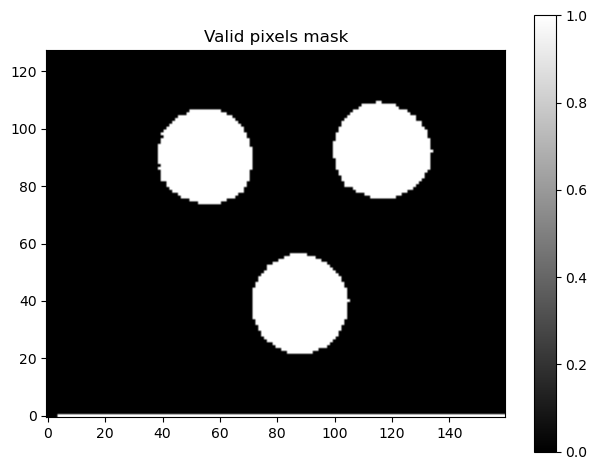

In [2]:
# Load mask
mask_path = os.path.join(folder_calibration, 'mask_3s_pyr.fits')
with fits.open(mask_path) as hdul:
    mask = hdul[0].data

print("valid_pix_mask shape:", mask.shape)

valid_pixels_indices = np.where(mask > 0)
npix_valid = valid_pixels_indices[0].shape[0]
print("valid pixels:", npix_valid)

# Save a visualization (PNG)
plt.figure()
plt.title('Valid pixels mask')
plt.imshow(mask, cmap='gray', origin='lower')
plt.colorbar()
plt.tight_layout()
mask_png = os.path.join(folder_data, 'valid_pixels_mask.png')
plt.savefig(mask_png, dpi=300)
plt.show()

## Reference Image

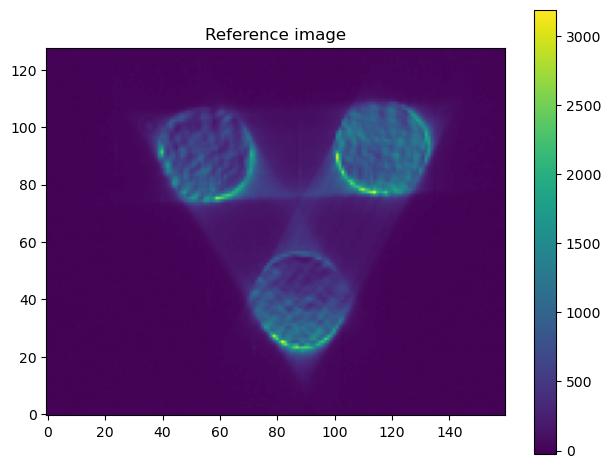

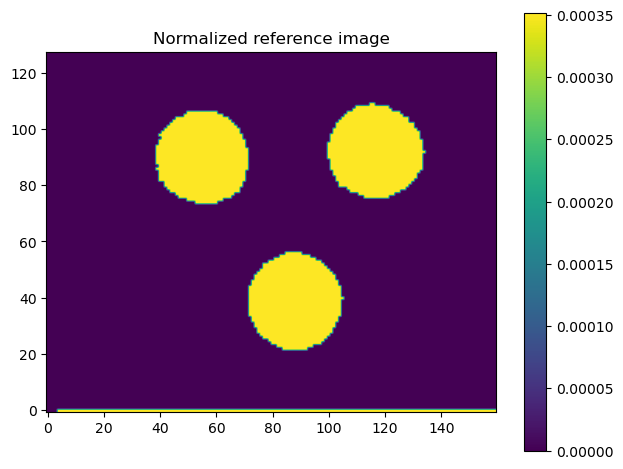

Saved plots:
- /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_03-12-37/reference_image.png
- /Volumes/SanDisk/PAPYRUS_run2/01.10.25/record/2025-10-02_03-12-37/normalized_reference_image.png


In [3]:
# Paths
ref_path = os.path.join(folder_calibration, 'reference_image_raw.fits')
#bias_path = os.path.join(folder_calibration, 'bias_image.fits')

reference_image = fits.getdata(ref_path).astype(np.float32)

# --- Save refrence image ---
plt.figure()
plt.title('Reference image')
plt.imshow(reference_image, origin='lower')
plt.colorbar()
plt.tight_layout()
ref_png = os.path.join(folder_data, 'reference_image.png')
plt.savefig(ref_png, dpi=300)
plt.show()

# Normalized reference image
ref_norm_path = os.path.join(folder_ARPOGE_data, 'reference_image_normalized.fits')
normalized_reference_image = fits.getdata(ref_norm_path).astype(np.float32)

# --- Save normalized image plot ---
plt.figure()
plt.title('Normalized reference image')
plt.imshow(normalized_reference_image, origin='lower')
plt.colorbar()
plt.tight_layout()
norm_png = os.path.join(folder_data, 'normalized_reference_image.png')
plt.savefig(norm_png, dpi=300)
plt.show()

print(f"Saved plots:\n- {ref_png}\n- {norm_png}")


## KL2C matrix

KL2C shape: (241, 195)


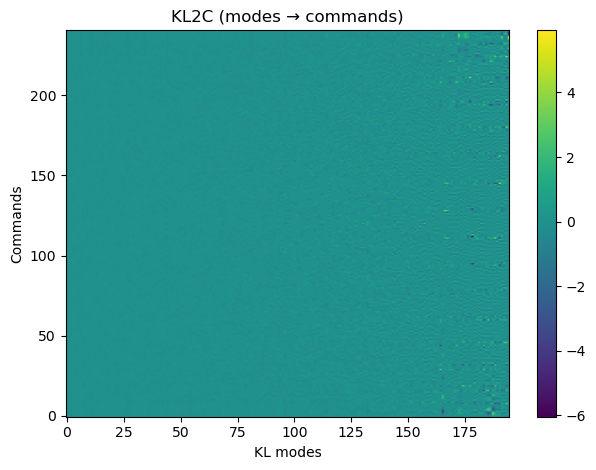

C2KL shape: (195, 241)


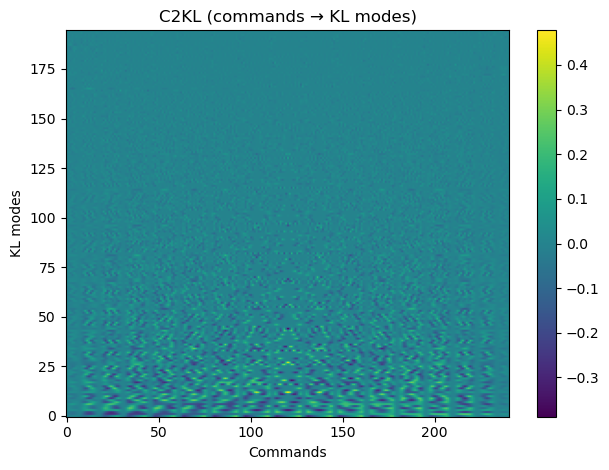

In [4]:
# Load KL2C (aka M2V) from FITS
kl2c_path = os.path.join(folder_data, 'M2V.fits')
KL2C = fits.getdata(kl2c_path).astype(np.float64)

print("KL2C shape:", KL2C.shape)

plt.figure()
plt.imshow(KL2C, aspect='auto', origin='lower')
plt.colorbar()
plt.title('KL2C (modes → commands)')
plt.xlabel('KL modes')
plt.ylabel('Commands')
plt.tight_layout()
plt.show()

# Unit scale for DM
DM_unit = 7.591  # µm

# Pseudoinverse: Commands → KL modes
C2KL = linalg.pinv(KL2C)           # base pseudoinverse
# C2KL = linalg.pinv(KL2C) * DM_unit  # µm-scaled mapping

print("C2KL shape:", C2KL.shape)

plt.figure()
plt.imshow(C2KL, aspect='auto', origin='lower')
plt.colorbar()
plt.title('C2KL (commands → KL modes)')
plt.xlabel('Commands')
plt.ylabel('KL modes')
plt.tight_layout()
plt.show()


## Push-Pull Cube

Cube shape: (195, 128, 160) dtype: >f4


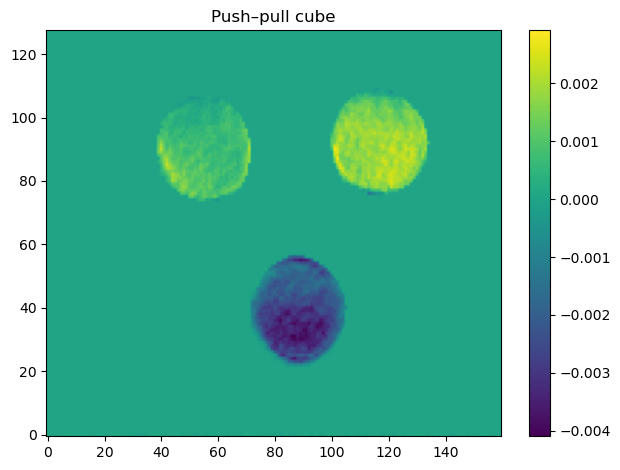

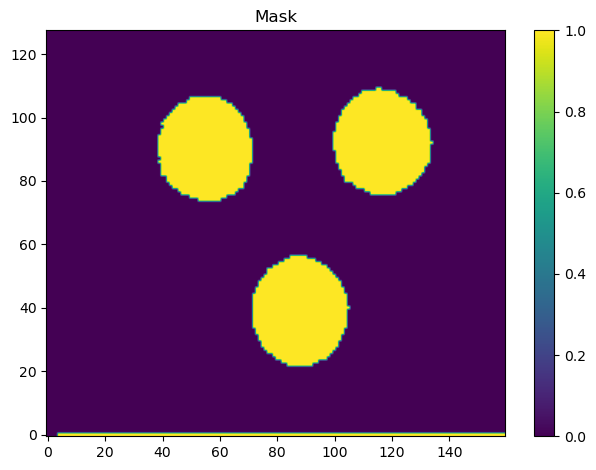

'\n# --- Fix colorbar range across all frames ---\nvmin = - 0.008 #float(np.nanmin(cube))\nvmax = 0.008 #float(np.nanmax(cube))\n\n# --- Render each frame with fixed colorbar and collect RGB images ---\nframes_rgb = []\nfor i in range(cube.shape[0]):\n    fig, ax = plt.subplots(figsize=(6, 4), dpi=150)\n    im = ax.imshow(cube[i], origin=\'lower\', aspect=\'auto\', vmin=vmin, vmax=vmax)\n    cbar = fig.colorbar(im, ax=ax)\n    ax.set_title(f\'Push–pull frame {i}\')\n    fig.tight_layout()\n\n    fig.canvas.draw()\n    w, h = fig.canvas.get_width_height()\n    rgb = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(h, w, 3)\n    frames_rgb.append(rgb)\n    plt.close(fig)\n\n# --- Save GIF from RGB frames (no warnings about float→uint8) ---\ngif_path = os.path.join(\'AObench/outputs/Calibration_files_papyrus_best/\', \'push_pull_images.gif\')\nfps = 8\nimageio.mimsave(gif_path, frames_rgb, duration=1.0 / fps, loop=0)\nprint(f"Saved GIF: {gif_path}")\n'

In [5]:
#Push-Pull images
cube_path = os.path.join(folder_calibration, 'processed_response_cube_KL2PWFS_push-pull_nact_17_amp_0.05_3s_pyr.fits')

cube = fits.getdata(cube_path, memmap=True)
print("Cube shape:", cube.shape, "dtype:", cube.dtype)

mask_new = np.zeros_like(cube[0,:,:])
mask_new[cube[0,:,:]!=0] = 1

%matplotlib inline
plt.figure()
plt.title('Push–pull cube')
plt.imshow(cube[0,:,:] , origin='lower', aspect='auto')
plt.colorbar()
plt.tight_layout()
plt.show()


# figure
plt.figure()
plt.title('Mask')
plt.imshow(mask, origin='lower', aspect='auto')
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(folder_calibration,"mask.png"), dpi=300)
plt.show()



"""
# --- Fix colorbar range across all frames ---
vmin = - 0.008 #float(np.nanmin(cube))
vmax = 0.008 #float(np.nanmax(cube))

# --- Render each frame with fixed colorbar and collect RGB images ---
frames_rgb = []
for i in range(cube.shape[0]):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
    im = ax.imshow(cube[i], origin='lower', aspect='auto', vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, ax=ax)
    ax.set_title(f'Push–pull frame {i}')
    fig.tight_layout()

    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    rgb = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(h, w, 3)
    frames_rgb.append(rgb)
    plt.close(fig)

# --- Save GIF from RGB frames (no warnings about float→uint8) ---
gif_path = os.path.join('AObench/outputs/Calibration_files_papyrus_best/', 'push_pull_images.gif')
fps = 8
imageio.mimsave(gif_path, frames_rgb, duration=1.0 / fps, loop=0)
print(f"Saved GIF: {gif_path}")
"""

## Intreaction Matrix

KL2S shape: (195, 2844)


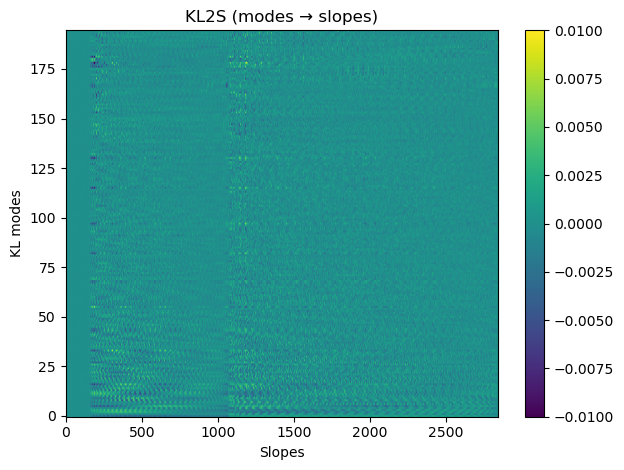

Shape of the reconstruction matrix: (195, 2844)


In [6]:
kl2s_3D_path = os.path.join(folder_calibration, 'processed_response_cube_KL2PWFS_push-pull_nact_17_amp_0.05_3s_pyr.fits')
KL2S_3D = fits.getdata(kl2s_3D_path)

imkl2s_path = os.path.join(folder_calibration, 'response_matrix_KL2S_filtered_nact_17_amp_0.05_3s_pyr.fits')
IM_KL2S = fits.getdata(imkl2s_path)
print("KL2S shape:", IM_KL2S.shape)

plt.figure()
plt.imshow(IM_KL2S, vmax=0.01, vmin=-0.01, aspect='auto', origin='lower')
plt.colorbar()
plt.title('KL2S (modes → slopes)')
plt.xlabel('Slopes')
plt.ylabel('KL modes')
plt.tight_layout()
plt.savefig(os.path.join(folder_data,"IM_KL2S.png"), dpi=300)
plt.show()

"""
IM_KL2S[IM_KL2S==0] = 1
IM_KL2S[IM_KL2S<1] = 0
plt.figure()
plt.imshow(IM_KL2S, aspect='auto', origin='lower')
plt.colorbar()
plt.title('KL2S (modes → slopes)')
plt.xlabel('Slopes')
plt.ylabel('KL modes')
plt.tight_layout()
plt.savefig(os.path.join('AObench/outputs/Calibration_files_papyrus_best',"IM_KL2S_with_zeros.png"), dpi=300)
plt.show()
"""

rms2kl_path = os.path.join(folder_ARPOGE_data, 'RM_S2KL.fits')
RM_S2KL = fits.getdata(rms2kl_path)
print(f"Shape of the reconstruction matrix: {RM_S2KL.shape}")